# Let's test to generate random variable through neural network

In [4]:
!pip install theano

Downloading/unpacking theano
  Running setup.py (path:/tmp/pip_build_root/theano/setup.py) egg_info for package theano
    
    
  Running setup.py install for theano
    changing mode of build/scripts-2.7/theano-cache from 644 to 755
    changing mode of build/scripts-2.7/theano-nose from 644 to 755
    changing mode of build/scripts-2.7/theano-test from 644 to 755
    
    
    changing mode of /usr/local/bin/theano-nose to 755
    changing mode of /usr/local/bin/theano-test to 755
    changing mode of /usr/local/bin/theano-cache to 755
  Could not find .egg-info directory in install record for theano
Cleaning up...


In [5]:
import numpy as np
import theano 
import theano.tensor as T
from theano.tensor.nnet import relu
from itertools import izip

class HiddenLayer(object):
    def __init__(self, shape, W=None, b=None, input=None, activation=relu):
        """Set Hidden Lyaer properties
        Args:
            shape (List(int)): determine layer shape as (n_in, n_out)
            W (theano.shared): intialize weight if you give some W
            b (theano.shared): intialize bias if you give some b
            activation: activation function
        """
        
        self.shape = shape
        self.activation = activation  
        
        if W is None:
            W_values = np.asarray(
                np.random.uniform(
                    low=-np.sqrt(6./np.sum(shape)), 
                    high=np.sqrt(6./np.sum(shape)),
                    size=shape
                ),
                dtype=theano.config.floatX
            )
            W = theano.shared(value=W_values, name="W", borrow=True)
            
        if b is None:
            b_values = np.zeros(shape[1], dtype=theano.config.floatX)
            b = theano.shared(value=b_values, name="b", borrow=True)
            
        self.W = W
        self.b = b
        self.params = [self.W, self.b]
        
    def batch_set_input(self, batch_input):
        self.batch_input = batch_input
        self.batch_output = self.activation(T.dot(self.batch_input, self.W) + self.b)
        
    def set_input(self, input):
        self.input = input
        self.output = self.activation(T.dot(self.input, self.W) + self.b)
        
    def output(self, x):
        y = self.activation(T.dot(x, self.W) + self.b)
        return y
        
class MLP(object):
    
    def __init__(self, *layers):
        """Get layer architecture
        Args:
            layers(list): contain each layer obejct like
                [HiddenLaer(10, 10), HiddenLayer(10, 10), HiddenLayer(10, 1)]
        """
        
        self.N_layers = len(layers)
        self.layers = layers
        
        # setting the input and output for training
        self.batch_input = T.dmatrix("batch_input")
        batch_input = self.batch_input
        for layer in self.layers:
            layer.batch_set_input(batch_input)
            batch_input = layer.batch_output
        self.batch_output = self.layers[-1].batch_output
        
        # setting the input and output
        self.input = T.dvector("input")
        input = self.input
        for layer in self.layers:
            layer.set_input(input)
            input = layer.output
        self.output = self.layers[-1].output
        
        self.output_func = theano.function(inputs=[self.input], outputs=self.output)
        
        #setting parameters
        self.params = [param for layer in self.layers for param in layer.params]
        
        
    def prediction(self, x):
        y = self.output_func(x)
        return y
    
            
    def SGD(self, input_data, target_data,
            learning_rate=0.0001, L1_reg=0.00, L2_reg=0.0001, N_epochs=10000, batch_size=20):
    
    
        N_data = len(input_data)
        N_batches = N_data / batch_size
        
        input_data = theano.shared(value=np.array(input_data, dtype=theano.config.floatX))
        target_data = theano.shared(value=np.array(target_data, dtype=theano.config.floatX))
            
        print ("...building the model")
        
        index = T.lscalar("index")
        target = T.dmatrix("target")
        cost = T.sum((target - self.batch_output) ** 2)
        
        gparams = [T.grad(cost=cost, wrt=param) for param in self.params]
        
        updates = [
            (param, param - learning_rate * gparam) for param, gparam in izip(self.params, gparams)
        ]
        
        batch_begin = index * batch_size
        batch_end = batch_begin + batch_size
        
        train_func = theano.function(
            inputs=[index],
            outputs=cost,
            updates=updates,
            givens = {
                self.batch_input:
                    input_data[batch_begin: batch_end],
                target:
                    target_data[batch_begin: batch_end]
            }
        )
        
        
        print "...training"
        
        print_epoch = 100
        
        for epoch in xrange(N_epochs):
            cost_data = []
            batch_list = np.arange(N_batches)
            np.random.shuffle(batch_list)
            for batch_index in iter(batch_list):
                c = train_func(batch_index)
                cost_data.append(c)
            average_cost = np.mean(cost_data) / batch_size
            
            if (epoch + 1) % print_epoch == 0:
                print ("epoch %d: cost = %f" % (epoch + 1, average_cost))

In [6]:
from itertools import izip


def data_generate(N_data, means = [-2.0, -1.0, 0, 1.0, 2.0], sigs = [2, 0.5, 1, 0.1, 1.5]):
    ret = []
    for m, s in izip(means, sigs):
        data = np.random.normal(loc=m, scale=s, size=N_data)
        ret.append(data)
    return np.array(ret).T


In [ ]:
input_data = data_generate(100000)

target_data = input_data.T[0]**2 *  np.tanh(input_data.T[1]) * np.sin(input_data.T[2]) / (1 + input_data.T[3]) \
    + 4 * input_data.T[4]
    
target_data = target_data.reshape(len(target_data), 1)

mlp = MLP(HiddenLayer(shape=(5, 100)), HiddenLayer(shape=(100, 1000)), HiddenLayer(shape=(1000, 100)), 
    HiddenLayer(shape=(100, 1), activation=lambda x: x))

mlp.SGD(input_data, target_data, N_epochs=1000)

...building the model
...training


KeyboardInterrupt: 

In [ ]:
new_input_data = data_generate(1000)

new_target_data = new_input_data.T[0]**2 * np.tanh(new_input_data.T[1]) * np.sin(new_input_data.T[2]) / (1 + new_input_data.T[3]) \
    + 4 * new_input_data.T[4]
    
predictions = np.array([mlp.prediction(data) for data in new_input_data])
cost = np.mean((predictions - new_target_data) ** 2)
print (cost)

In [ ]:
a = np.arange(10)
np.random.shuffle(a)
print (a)

# Let's use Echo State Network

Fetch Finance Data!

In [7]:
!pip install matplotlib --upgrade

Requirement already up-to-date: matplotlib in /usr/local/lib/python2.7/dist-packages
Requirement already up-to-date: numpy>=1.6 in /usr/local/lib/python2.7/dist-packages (from matplotlib)
Requirement already up-to-date: python-dateutil in /usr/local/lib/python2.7/dist-packages (from matplotlib)
Requirement already up-to-date: pytz in /usr/local/lib/python2.7/dist-packages (from matplotlib)
Requirement already up-to-date: cycler in /usr/local/lib/python2.7/dist-packages (from matplotlib)
Requirement already up-to-date: pyparsing!=2.0.4,>=1.5.6 in /usr/local/lib/python2.7/dist-packages (from matplotlib)
Cleaning up...


In [8]:
#generic
%matplotlib inline
from __future__ import print_function

#public open pakcages and methods
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#private pakcages and methods
import histdata
from utils import parse_json
from nb_utils import compare
from trading import tm
import tseries
from tseries.converter import Converter

#for testing
from IPython import display
import platform
import time

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [4]:
import histdata
from trading import tm

parse_datetime = tm.T.parser("%Y%m%d%H%M")
st = parse_datetime("201501010000")
end = parse_datetime("201601010000")

df = histdata.get_candles(symbol="EURUSD", timeframe="5Min", start=st, end=end)

high_data = np.array(df['high'])
low_data = np.array(df['low'])
open_data = np.array(df['open'])
close_data = np.array(df['close'])

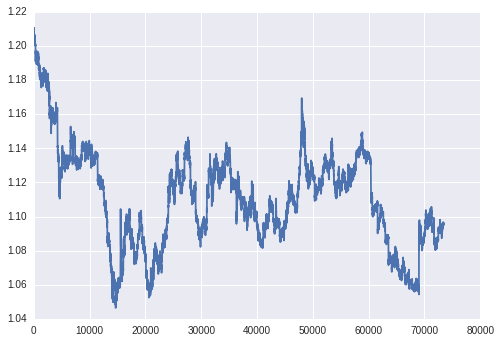

In [7]:
plt.plot(open_data)

As an experiment, we are going to analize yahoo data

In [9]:
from yahoo_finance import Share

def get_data_by_key(key, data):
    data_it = iter(data)
    return_data = []
    for d in data_it:
        return_data.append(d[key])
    return np.array(return_data)

def get_data_by_list(name_list, start_date, end_date, data_type="Open"):
    share_list = []
    for name in name_list:
        share_list.append(Share(name))
    
    stock_data = []
    date = []
    for share in share_list:
        hist_data = share.get_historical(start_date=start_date, end_date=end_date)
        stock_data.append(np.asarray(get_data_by_key(key=data_type, data=hist_data), dtype=float))
        date.append(get_data_by_key(key='Date', data=hist_data))
    return np.array(stock_data).T, date


In [60]:
#off line Echo state network

class ESN(object):
    
    def __init__(
            self, N_in, N_middle, N_out, 
            activation=np.tanh, activation_out=lambda x: x,
            activation_out_inv=lambda x: x,
            dense=0.15, scale=0.8, alpha=1.0, 
            W_in=None, W_middle=None, W_out=None
        ):
        """shape feature
        Args:
            N_in (int): The dimention of input
            N_middle (int): the number of hidden nodes
            N_out (int): the dimention of output
            activation (lambda): activation function of middle layer
            activation_out (lambda):
                activation function for output
            activation_out_inv (lambda):
                inverse function of activation_out
            dense (float): the degree of sparsity of W_in and W_middle
            scale (float): the scale of W_middle
            alpha (float): initialization for W_in and W_middle
                uniform_dist [-alpha, alpha]
            W_* (np.array): weitght for each layer
        """
        
        self.N_in = N_in
        self.N_out = N_out
        self.N_middle = N_middle
        self.activation = activation
        self.activation_out = activation_out
        self.activation_out_inv = activation_out_inv
        self.middle = np.zeros(shape=self.N_middle)
    
        if W_middle is None:
            # the number of non-zero elements
            num_w = int(N_middle * N_middle * dense)
            W_middle = np.zeros(shape=(N_middle, N_middle))
            for i in xrange(num_w):
                row = np.random.randint(low=0, high=N_middle)
                col = np.random.randint(low=0, high=N_middle)
                while(W_middle[row][col] != 0):
                    row = np.random.randint(low=0, high=N_middle)
                    col = np.random.randint(low=0, high=N_middle)
                u = np.random.uniform(low=-alpha, high=alpha)
                W_middle[row][col] = u
            #normalization
            eig_max = np.max(np.abs(np.linalg.eigvals(W_middle)))
            W_middle = W_middle / eig_max * scale
        self.W_middle = W_middle
        
        if W_in is None:
            # the number of non-zero elements
            num_w = int(N_in * N_middle  * dense)
            W_in = np.zeros(shape=(N_middle, N_in))
            for i in xrange(num_w):
                row = np.random.randint(low=0, high=N_middle)
                col = np.random.randint(low=0, high=N_in)
                while(W_middle[row][col] != 0):
                    row = np.random.randint(low=0, high=N_middle)
                    col = np.random.randint(low=0, high=N_in)
                u = np.random.uniform(low=-alpha, high=alpha)
                W_in[row][col] = u
        self.W_in = W_in
        
        if W_out is None:
            W_out = np.random.randn(N_out, N_middle + N_in)
        self.W_out = W_out
        
    def learning(self, input_data, target_data, start_time, L2=1.0e-2):
        N_data = len(input_data)
        Y = []
        X = []
        #noise scale
        sig = 1.0e-4
        #initalization
        middle = np.zeros(shape=self.N_middle)
        output = np.zeros(shape=self.N_out)
        middle_data = []
        for i in xrange(N_data):
            new_m = self.activation(np.dot(self.W_in, input_data[i]))\
                                    + np.dot(self.W_middle, middle) + sig*np.random.randn(self.N_middle)
            
            if i >= start_time:
                # minimize ||Y - X * W.T|| ** 2+ L2 * ||W|| ** 2
                Y.append(self.activation_out_inv(target_data[i]))
                X.append(np.concatenate((input_data[i], new_m)))
            
            
            middle = new_m  
            middle_data.append(middle)
            
        Y = np.array(Y)
        X = np.array(X)
        #keep middel data for predcition
        self.middle = middle
                                    
        if L2 == 0:
            X_inv = np.real(np.linalg.pinv(X.T))
        else:
            X_inv = np.dot(X, np.linalg.inv(L2 * np.identity(self.N_in + self.N_middle) + np.dot(X.T, X)))
        self.W_out = np.dot(Y.T, X_inv)
        pre_out = np.c_[input_data, middle_data]
        return self.activation_out(np.dot(self.W_out, pre_out.T).T)
    
    def predict(self, input_data):
        output_data = []
        N_data = len(input_data)
        #initalization
        middle = self.middle
        for i in xrange(N_data):
            new_m = self.activation(np.dot(self.W_in, input_data[i]) \
                                    + np.dot(self.W_middle, middle))
            output = self.activation_out(np.dot(self.W_out, np.r_[input_data[i], new_m]))
            output_data.append(output)
            
        return np.array(output_data)

(253, 1)
(253, 1)


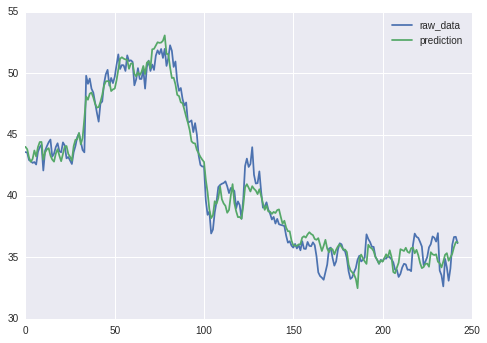

In [61]:
target_list = ['YHOO']
input_list = ["AAPL", "ORCL", "IBM", "INTC"]

start_date="2014-04-01"
end_date="2015-04-01"
input_data, date = get_data_by_list(input_list, start_date=start_date, end_date=end_date) 
target_data, date = get_data_by_list(target_list, start_date=start_date, end_date=end_date) 

T = len(input_data)
N_middle = T 
esn = ESN(N_in=len(input_data[0]), N_middle=N_middle, N_out=len(target_data[0]))
start_time = 10
output_data = esn.learning(input_data=input_data, target_data=target_data, start_time=start_time)


plt.plot(target_data[start_time:], label="raw_data")
plt.plot(output_data.T[0][start_time:], label="prediction")
plt.legend()

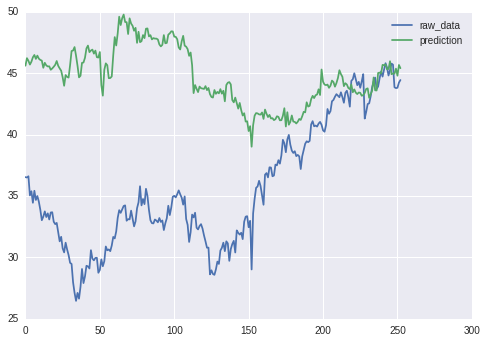

In [62]:
target_list = ['YHOO']
input_list = ["AAPL", "ORCL", "IBM", "INTC"]

start_date="2015-04-01"
end_date="2016-04-01"
input_data, date = get_data_by_list(input_list, start_date=start_date, end_date=end_date) 
target_data, date = get_data_by_list(target_list, start_date=start_date, end_date=end_date) 

output_data = esn.predict(input_data)

plt.plot(target_data, label="raw_data")
plt.plot(output_data.T[0], label="prediction")
plt.legend()

Hmmm.... That doesn't look pretty nice

Let's try prediction for just one month 

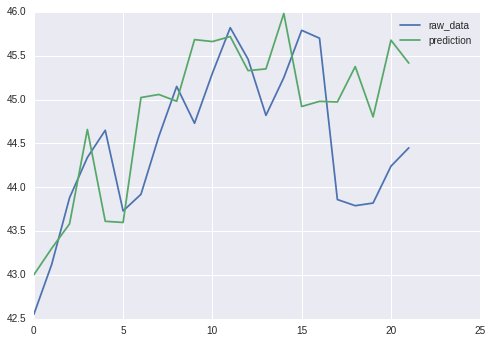

In [63]:
target_list = ['YHOO']
input_list = ["AAPL", "ORCL", "IBM", "INTC"]

start_date="2015-04-01"
end_date="2015-05-01"
input_data, date = get_data_by_list(input_list, start_date=start_date, end_date=end_date) 
target_data, date = get_data_by_list(target_list, start_date=start_date, end_date=end_date) 

output_data = esn.predict(input_data)

plt.plot(target_data, label="raw_data")
plt.plot(output_data.T[0], label="prediction")
plt.legend()

We are gonna work on more complex model!

learning time: 7.679382


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:21: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


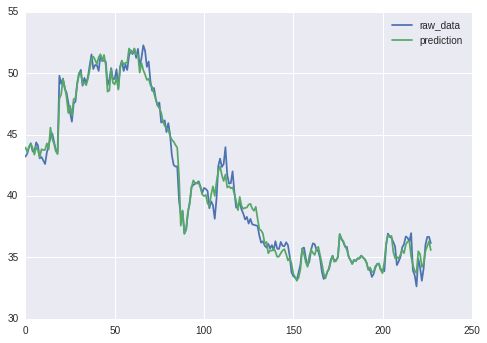

In [67]:
import time 

target_list = ['YHOO']
input_list = ["AAPL", "ORCL", "IBM", "INTC"]

start_date="2014-04-01"
end_date="2015-04-01"
input_data, date = get_data_by_list(input_list, start_date=start_date, end_date=end_date) 
target_data, date = get_data_by_list(target_list, start_date=start_date, end_date=end_date) 

T = len(input_data)
N_middle = T * 5 
esn = ESN(N_in=len(input_data[0]), N_middle=N_middle, N_out=len(target_data[0]))
start_time = T * 0.1
st = time.time()
output_data = esn.learning(input_data=input_data, target_data=target_data, start_time=start_time)
elapsed = time.time() - st 

print ("learning time: %f" % elapsed)
plt.plot(target_data[start_time:], label="raw_data")
plt.plot(output_data.T[0][start_time:], label="prediction")
plt.legend()

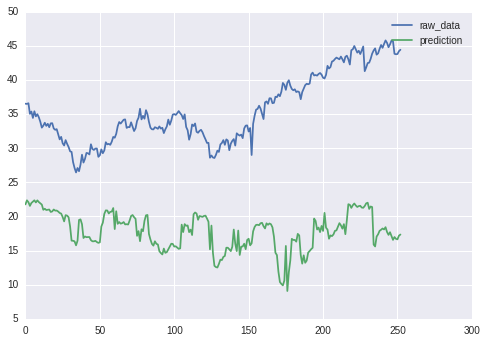

In [68]:
target_list = ['YHOO']
input_list = ["AAPL", "ORCL", "IBM", "INTC"]

start_date="2015-04-01"
end_date="2016-04-01"
input_data, date = get_data_by_list(input_list, start_date=start_date, end_date=end_date) 
target_data, date = get_data_by_list(target_list, start_date=start_date, end_date=end_date) 

output_data = esn.predict(input_data)

plt.plot(target_data, label="raw_data")
plt.plot(output_data.T[0], label="prediction")
plt.legend()

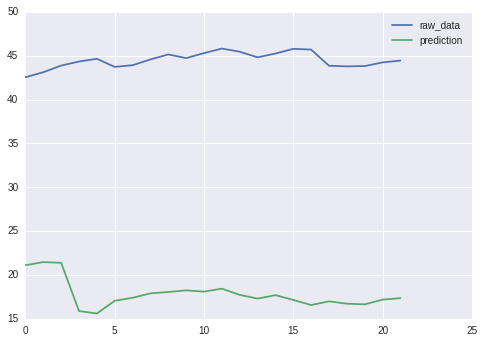

In [69]:
target_list = ['YHOO']
input_list = ["AAPL", "ORCL", "IBM", "INTC"]

start_date="2015-04-01"
end_date="2015-05-01"
input_data, date = get_data_by_list(input_list, start_date=start_date, end_date=end_date) 
target_data, date = get_data_by_list(target_list, start_date=start_date, end_date=end_date) 

output_data = esn.predict(input_data)

plt.plot(target_data, label="raw_data")
plt.plot(output_data.T[0], label="prediction")
plt.legend()

learning time: 55.665440


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:21: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


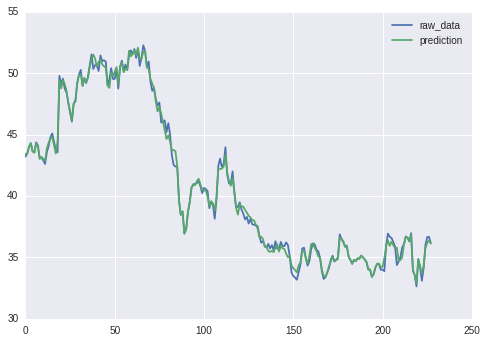

In [70]:
import time 

target_list = ['YHOO']
input_list = ["AAPL", "ORCL", "IBM", "INTC"]

start_date="2014-04-01"
end_date="2015-04-01"
input_data, date = get_data_by_list(input_list, start_date=start_date, end_date=end_date) 
target_data, date = get_data_by_list(target_list, start_date=start_date, end_date=end_date) 

T = len(input_data)
N_middle = T * 10 
esn = ESN(N_in=len(input_data[0]), N_middle=N_middle, N_out=len(target_data[0]))
start_time = T * 0.1
st = time.time()
output_data = esn.learning(input_data=input_data, target_data=target_data, start_time=start_time)
elapsed = time.time() - st 

print ("learning time: %f" % elapsed)
plt.plot(target_data[start_time:], label="raw_data")
plt.plot(output_data.T[0][start_time:], label="prediction")
plt.legend()

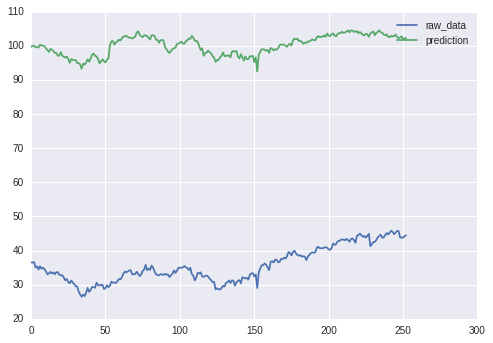

In [71]:
target_list = ['YHOO']
input_list = ["AAPL", "ORCL", "IBM", "INTC"]

start_date="2015-04-01"
end_date="2016-04-01"
input_data, date = get_data_by_list(input_list, start_date=start_date, end_date=end_date) 
target_data, date = get_data_by_list(target_list, start_date=start_date, end_date=end_date) 

output_data = esn.predict(input_data)

plt.plot(target_data, label="raw_data")
plt.plot(output_data.T[0], label="prediction")
plt.legend()

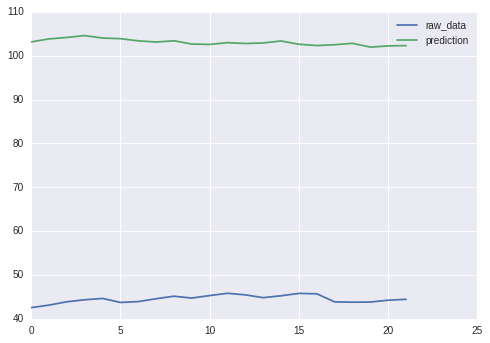

In [72]:
target_list = ['YHOO']
input_list = ["AAPL", "ORCL", "IBM", "INTC"]

start_date="2015-04-01"
end_date="2015-05-01"
input_data, date = get_data_by_list(input_list, start_date=start_date, end_date=end_date) 
target_data, date = get_data_by_list(target_list, start_date=start_date, end_date=end_date) 

output_data = esn.predict(input_data)

plt.plot(target_data, label="raw_data")
plt.plot(output_data.T[0], label="prediction")
plt.legend()

That looks the problem of bias. Let's introduce bias

# Model with bias

In [109]:
class ESN2(object):
    
    def __init__(
            self, N_in, N_middle, N_out, 
            activation=np.tanh, activation_out=lambda x: x,
            activation_out_inv=lambda x: x,
            dense=0.15, scale=0.8, alpha=1.0, 
            W_in=None, W_middle=None, W_out=None
        ):
        """shape feature
        Args:
            N_in (int): The dimention of input
            N_middle (int): the number of hidden nodes
            N_out (int): the dimention of output
            activation (lambda): activation function of middle layer
            activation_out (lambda):
                activation function for output
            activation_out_inv (lambda):
                inverse function of activation_out
            dense (float): the degree of sparsity of W_in and W_middle
            scale (float): the scale of W_middle
            alpha (float): initialization for W_in and W_middle
                uniform_dist [-alpha, alpha]
            W_* (np.array): weitght for each layer
        """
        
        self.N_in = N_in
        self.N_out = N_out
        self.N_middle = N_middle
        self.activation = activation
        self.activation_out = activation_out
        self.activation_out_inv = activation_out_inv
        self.middle = np.zeros(shape=self.N_middle)
    
        if W_middle is None:
            # the number of non-zero elements
            num_w = int(N_middle * N_middle * dense)
            W_middle = np.zeros(shape=(N_middle, N_middle))
            for i in xrange(num_w):
                row = np.random.randint(low=0, high=N_middle)
                col = np.random.randint(low=0, high=N_middle)
                while(W_middle[row][col] != 0):
                    row = np.random.randint(low=0, high=N_middle)
                    col = np.random.randint(low=0, high=N_middle)
                u = np.random.uniform(low=-alpha, high=alpha)
                W_middle[row][col] = u
            #normalization
            eig_max = np.max(np.abs(np.linalg.eigvals(W_middle)))
            W_middle = W_middle / eig_max * scale
        self.W_middle = W_middle
        
        if W_in is None:
            # the number of non-zero elements
            num_w = int(N_in * N_middle  * dense)
            W_in = np.zeros(shape=(N_middle, N_in))
            for i in xrange(num_w):
                row = np.random.randint(low=0, high=N_middle)
                col = np.random.randint(low=0, high=N_in)
                while(W_middle[row][col] != 0):
                    row = np.random.randint(low=0, high=N_middle)
                    col = np.random.randint(low=0, high=N_in)
                u = np.random.uniform(low=-alpha, high=alpha)
                W_in[row][col] = u
            # bias
            bias_in = np.random.uniform(low=-alpha, high=alpha, size=N_middle)
            W_in = np.c_[bias_in, W_in]
        self.W_in = W_in
        
        
    def learning(self, input_data, target_data, start_time, L2=1.0e-2, sig=1.0e-3):
        N_data = len(input_data)
        Y = []
        X = []
        #initalization
        middle = np.zeros(shape=self.N_middle)
        output = np.zeros(shape=self.N_out)
        middle_data = []
        for i in xrange(N_data):
            new_m = self.activation(np.dot(self.W_in, np.r_[1.0, input_data[i]]))\
                                    + np.dot(self.W_middle, middle) + sig*np.random.randn(self.N_middle)
            
            if i >= start_time:
                # minimize ||Y - X * W.T|| ** 2+ L2 * ||W|| ** 2
                Y.append(self.activation_out_inv(target_data[i]))
                X.append(np.r_[1.0, input_data[i], new_m])
            
            middle = new_m  
            middle_data.append(middle)
            
        Y = np.array(Y)
        X = np.array(X)
        #keep middel data for predcition
        self.middle = middle
                                    
        if L2 == 0:
            X_inv = np.real(np.linalg.pinv(X.T))
        else:
            X_inv = np.dot(X, np.linalg.inv(L2 * np.identity(self.N_in + self.N_middle + 1) + np.dot(X.T, X)))
        self.W_out = np.dot(Y.T, X_inv)
        pre_out = np.c_[np.ones(N_data), input_data, middle_data]
        return self.activation_out(np.dot(self.W_out, pre_out.T).T)
    
    def predict(self, input_data):
        output_data = []
        N_data = len(input_data)
        #initalization
        middle = self.middle
        for i in xrange(N_data):
            new_m = self.activation(np.dot(self.W_in, np.r_[1.0, input_data[i]]) \
                                    + np.dot(self.W_middle, middle))
            output = self.activation_out(np.dot(self.W_out, np.r_[1.0, input_data[i], new_m]))
            output_data.append(output)
            
        return np.array(output_data)

learning time: 7.389897


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:19: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


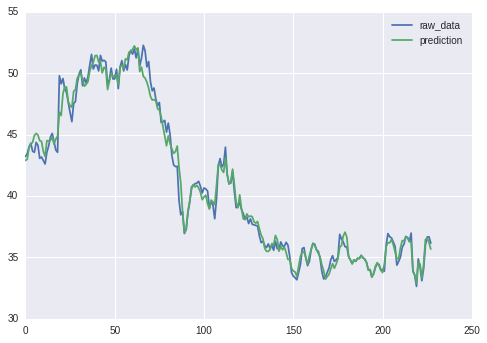

In [110]:
target_list = ['YHOO']
input_list = ["AAPL", "ORCL", "IBM", "INTC"]

start_date="2014-04-01"
end_date="2015-04-01"
input_data, date = get_data_by_list(input_list, start_date=start_date, end_date=end_date) 
target_data, date = get_data_by_list(target_list, start_date=start_date, end_date=end_date) 

T = len(input_data)
N_middle = T * 5
esn = ESN2(N_in=len(input_data[0]), N_middle=N_middle, N_out=len(target_data[0]))
start_time = T * 0.1
st = time.time()
output_data = esn.learning(input_data=input_data, target_data=target_data, start_time=start_time)
elapsed = time.time() - st 

print ("learning time: %f" % elapsed)
plt.plot(target_data[start_time:], label="raw_data")
plt.plot(output_data.T[0][start_time:], label="prediction")
plt.legend()

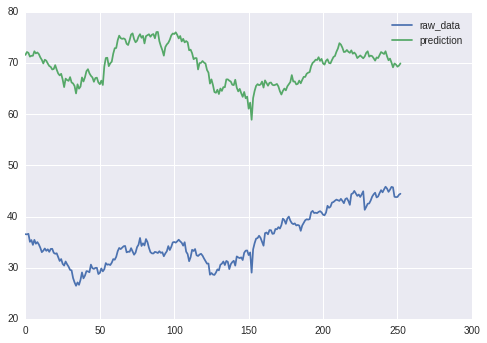

In [111]:
target_list = ['YHOO']
input_list = ["AAPL", "ORCL", "IBM", "INTC"]

start_date="2015-04-01"
end_date="2016-04-01"
input_data, date = get_data_by_list(input_list, start_date=start_date, end_date=end_date) 
target_data, date = get_data_by_list(target_list, start_date=start_date, end_date=end_date) 

output_data = esn.predict(input_data)

plt.plot(target_data, label="raw_data")
plt.plot(output_data.T[0], label="prediction")
plt.legend()

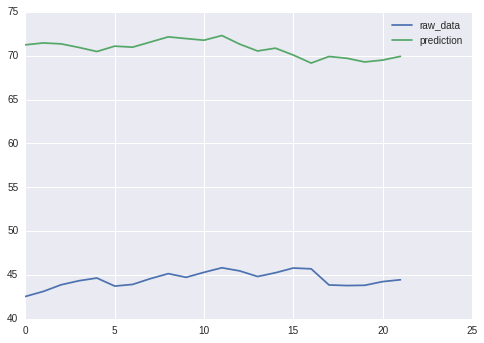

In [112]:
target_list = ['YHOO']
input_list = ["AAPL", "ORCL", "IBM", "INTC"]

start_date="2015-04-01"
end_date="2015-05-01"
input_data, date = get_data_by_list(input_list, start_date=start_date, end_date=end_date) 
target_data, date = get_data_by_list(target_list, start_date=start_date, end_date=end_date) 

output_data = esn.predict(input_data)

plt.plot(target_data, label="raw_data")
plt.plot(output_data.T[0], label="prediction")
plt.legend()

That looks producing similar shape patter, but there is still bias gap between prediction and testdata

Let's establish model with scaling.

# Model with scaling

In [172]:
class ESN3(object):
    
    def __init__(
            self, N_in, N_middle, N_out, 
            activation=np.tanh, activation_out=lambda x: x,
            activation_out_inv=lambda x: x,
            dense=0.15, scale=0.8, alpha=1.0, 
            W_in=None, W_middle=None, W_out=None
        ):
        """shape feature
        Args:
            N_in (int): The dimention of input
            N_middle (int): the number of hidden nodes
            N_out (int): the dimention of output
            activation (lambda): activation function of middle layer
            activation_out (lambda):
                activation function for output
            activation_out_inv (lambda):
                inverse function of activation_out
            dense (float): the degree of sparsity of W_in and W_middle
            scale (float): the scale of W_middle
            alpha (float): initialization for W_in and W_middle
                uniform_dist [-alpha, alpha]
            W_* (np.array): weitght for each layer
        """
        
        self.N_in = N_in
        self.N_out = N_out
        self.N_middle = N_middle
        self.activation = activation
        self.activation_out = activation_out
        self.activation_out_inv = activation_out_inv
        self.middle = np.zeros(shape=self.N_middle)
    
        if W_middle is None:
            # the number of non-zero elements
            num_w = int(N_middle * N_middle * dense)
            W_middle = np.zeros(shape=(N_middle, N_middle))
            for i in xrange(num_w):
                row = np.random.randint(low=0, high=N_middle)
                col = np.random.randint(low=0, high=N_middle)
                while(W_middle[row][col] != 0):
                    row = np.random.randint(low=0, high=N_middle)
                    col = np.random.randint(low=0, high=N_middle)
                u = np.random.uniform(low=-alpha, high=alpha)
                W_middle[row][col] = u
            #normalization
            eig_max = np.max(np.abs(np.linalg.eigvals(W_middle)))
            W_middle = W_middle / eig_max * scale
        self.W_middle = W_middle
        
        if W_in is None:
            # the number of non-zero elements
            num_w = int(N_in * N_middle  * dense)
            W_in = np.zeros(shape=(N_middle, N_in))
            for i in xrange(num_w):
                row = np.random.randint(low=0, high=N_middle)
                col = np.random.randint(low=0, high=N_in)
                while(W_in[row][col] != 0):
                    row = np.random.randint(low=0, high=N_middle)
                    col = np.random.randint(low=0, high=N_in)
                u = np.random.uniform(low=-alpha, high=alpha)
                W_in[row][col] = u
            # bias
            num_b = int(N_middle  * dense)
            bias_in = np.zeros(shape=N_middle)
            for i in xrange(num_b):
                row = np.random.randint(low=0, high=N_middle)
                while(bias_in[row] != 0):
                    row = np.random.randint(low=0, high=N_middle)
                u = np.random.uniform(low=-alpha, high=alpha)
                bias_in[row] = u
            W_in = np.c_[bias_in, W_in]
        self.W_in = W_in
        
        
    def learning(self, input_data, target_data, start_time, L2=1.0e-2, sig=1.0e-3):
        N_data = len(input_data)
        Y = []
        X = []
        # initalization
        middle = np.zeros(shape=self.N_middle)
        output = np.zeros(shape=self.N_out)
        middle_data = []
        for i in xrange(N_data):
            new_m = self.activation(np.dot(self.W_in, np.r_[1.0, input_data[i]]))\
                                    + np.dot(self.W_middle, middle) + sig*np.random.randn(self.N_middle)
            
            if i >= start_time:
                # minimize ||Y - X * W.T|| ** 2+ L2 * ||W|| ** 2
                Y.append(self.activation_out_inv(target_data[i]))
                X.append(np.r_[1.0, input_data[i], new_m])
            
            middle = new_m  
            middle_data.append(middle)
            
        Y = np.array(Y)
        X = np.array(X)
        #keep middel data for predcition
        self.middle = middle
                                    
        if L2 == 0:
            X_inv = np.real(np.linalg.pinv(X.T))
        else:
            X_inv = np.dot(X, np.linalg.inv(L2 * np.identity(self.N_in + self.N_middle + 1) + np.dot(X.T, X)))
        self.W_out = np.dot(Y.T, X_inv)
        pre_out = np.c_[np.ones(N_data), input_data, middle_data]
        return self.activation_out(np.dot(self.W_out, pre_out.T).T)
    
    def predict(self, input_data):
        output_data = []
        N_data = len(input_data)
        #initalization
        middle = self.middle.copy()
        for i in xrange(N_data):
            new_m = self.activation(np.dot(self.W_in, np.r_[1.0, input_data[i]]) \
                                    + np.dot(self.W_middle, middle))
            output = self.activation_out(np.dot(self.W_out, np.r_[1.0, input_data[i], new_m]))
            middle = new_m
            output_data.append(output)
            
        return np.array(output_data)

learning time: 0.122655


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:19: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


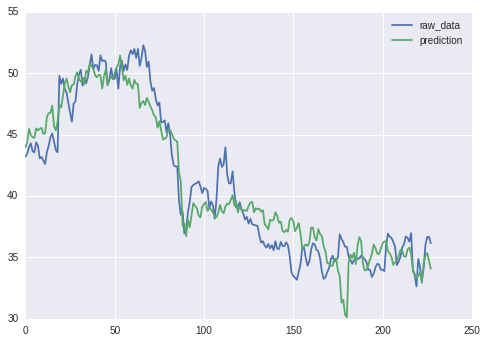

In [173]:
target_list = ['YHOO']
input_list = ["AAPL", "ORCL", "IBM", "INTC"]

start_date="2014-04-01"
end_date="2015-04-01"
input_data, date = get_data_by_list(input_list, start_date=start_date, end_date=end_date) 
target_data, date = get_data_by_list(target_list, start_date=start_date, end_date=end_date) 

T = len(input_data)
N_middle = T 
esn = ESN3(N_in=len(input_data[0]), N_middle=N_middle, N_out=len(target_data[0]))
start_time = T * 0.1
st = time.time()
output_data = esn.learning(input_data=input_data, target_data=target_data, start_time=start_time)
elapsed = time.time() - st 

print ("learning time: %f" % elapsed)
plt.plot(target_data[start_time:], label="raw_data")
plt.plot(output_data.T[0][start_time:], label="prediction")
plt.legend()

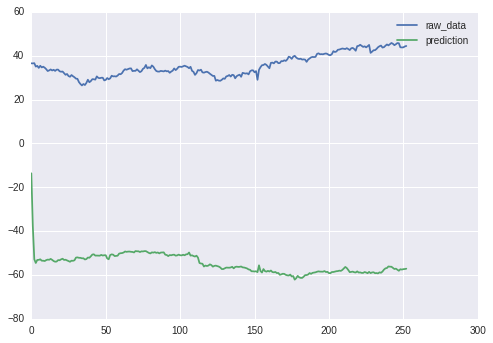

In [174]:
target_list = ['YHOO']
input_list = ["AAPL", "ORCL", "IBM", "INTC"]

start_date="2015-04-01"
end_date="2016-04-01"
input_data, date = get_data_by_list(input_list, start_date=start_date, end_date=end_date) 
target_data, date = get_data_by_list(target_list, start_date=start_date, end_date=end_date) 

output_data = esn.predict(input_data)

plt.plot(target_data, label="raw_data")
plt.plot(output_data.T[0], label="prediction")
plt.legend()

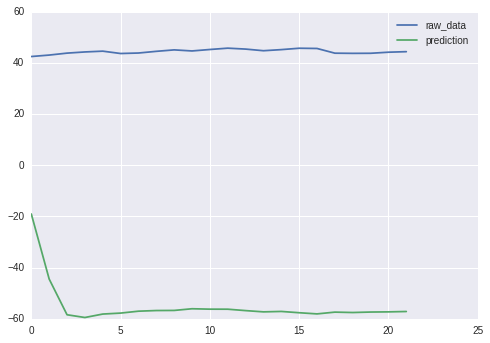

In [175]:
target_list = ['YHOO']
input_list = ["AAPL", "ORCL", "IBM", "INTC"]

start_date="2015-04-01"
end_date="2015-05-01"
input_data, date = get_data_by_list(input_list, start_date=start_date, end_date=end_date) 
target_data, date = get_data_by_list(target_list, start_date=start_date, end_date=end_date) 

output_data = esn.predict(input_data)

plt.plot(target_data, label="raw_data")
plt.plot(output_data.T[0], label="prediction")
plt.legend()

# Stop Scaling

In [237]:
class ESN4(object):
    
    def __init__(
            self, N_in, N_middle, N_out, 
            activation=np.tanh, activation_out=lambda x: x,
            activation_out_inv=lambda x: x,
            dense=0.15, scale=0.8, alpha=1.0, 
            W_in=None, W_middle=None, W_out=None
        ):
        """shape feature
        Args:
            N_in (int): The dimention of input
            N_middle (int): the number of hidden nodes
            N_out (int): the dimention of output
            activation (lambda): activation function of middle layer
            activation_out (lambda):
                activation function for output
            activation_out_inv (lambda):
                inverse function of activation_out
            dense (float): the degree of sparsity of W_in and W_middle
            scale (float): the scale of W_middle
            alpha (float): initialization for W_in and W_middle
                uniform_dist [-alpha, alpha]
            W_* (np.array): weitght for each layer
        """
        
        self.N_in = N_in
        self.N_out = N_out
        self.N_middle = N_middle
        self.activation = activation
        self.activation_out = activation_out
        self.activation_out_inv = activation_out_inv
        self.middle = np.zeros(shape=self.N_middle)
    
        if W_middle is None:
            # the number of non-zero elements
            num_w = int(N_middle * N_middle * dense)
            W_middle = np.zeros(shape=(N_middle, N_middle))
            for i in xrange(num_w):
                row = np.random.randint(low=0, high=N_middle)
                col = np.random.randint(low=0, high=N_middle)
                while(W_middle[row][col] != 0):
                    row = np.random.randint(low=0, high=N_middle)
                    col = np.random.randint(low=0, high=N_middle)
                u = np.random.uniform(low=-alpha, high=alpha)
                W_middle[row][col] = u
            #normalization
            eig_max = np.max(np.abs(np.linalg.eigvals(W_middle)))
            W_middle = W_middle / eig_max * scale
        self.W_middle = W_middle
        
        if W_in is None:
            # the number of non-zero elements
            num_w = int(N_in * N_middle  * dense)
            W_in = np.zeros(shape=(N_middle, N_in))
            for i in xrange(num_w):
                row = np.random.randint(low=0, high=N_middle)
                col = np.random.randint(low=0, high=N_in)
                while(W_in[row][col] != 0):
                    row = np.random.randint(low=0, high=N_middle)
                    col = np.random.randint(low=0, high=N_in)
                u = np.random.uniform(low=-alpha, high=alpha)
                W_in[row][col] = u
            # bias
            num_b = int(N_middle  * dense)
            bias_in = np.zeros(shape=N_middle)
            for i in xrange(num_b):
                row = np.random.randint(low=0, high=N_middle)
                while(bias_in[row] != 0):
                    row = np.random.randint(low=0, high=N_middle)
                u = np.random.uniform(low=-alpha, high=alpha)
                bias_in[row] = u
            W_in = np.c_[bias_in, W_in]
        self.W_in = W_in
        
        
    def learning(self, input_data, target_data, start_time, L2=1.0e-2, sig=1.0e-2):
        N_data = len(input_data)
        Y = []
        X = []
        # initalization
        middle = np.zeros(shape=self.N_middle)
        output = np.zeros(shape=self.N_out)
        middle_data = []
        for i in xrange(N_data):
            new_m = self.activation(
                np.dot(self.W_in, np.r_[1.0, input_data[i]]) \
                + np.dot(self.W_middle, middle)
                )\
                + sig*np.random.randn(self.N_middle)
            
            if i >= start_time:
                # minimize ||Y - X * W.T|| ** 2+ L2 * ||W|| ** 2
                Y.append(self.activation_out_inv(target_data[i]))
                X.append(np.r_[1.0, input_data[i], new_m])
            
            middle = new_m  
            middle_data.append(middle)
            
        Y = np.array(Y)
        X = np.array(X)
        #keep middle data for predcition
        self.middle = middle
                                    
        if L2 == 0:
            X_inv = np.real(np.linalg.pinv(X.T))
        else:
            X_inv = np.dot(X, np.linalg.inv(L2 * np.identity(self.N_in + self.N_middle + 1) + np.dot(X.T, X)))
        self.W_out = np.dot(Y.T, X_inv)
        pre_out = np.c_[np.ones(N_data), input_data, middle_data]
        return self.activation_out(np.dot(self.W_out, pre_out.T).T)
    
    def predict(self, input_data, sig=0):
        output_data = []
        N_data = len(input_data)
        #initalization
        middle = self.middle.copy()
        for i in xrange(N_data):
            new_m = self.activation(
                np.dot(self.W_in, np.r_[1.0, input_data[i]]) \
                + np.dot(self.W_middle, middle)
                )\
                + sig*np.random.randn(self.N_middle)
            output = self.activation_out(np.dot(self.W_out, np.r_[1.0, input_data[i], new_m]))
            middle = new_m
            output_data.append(output)
            
        return np.array(output_data)

learning time: 7.310050


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:19: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


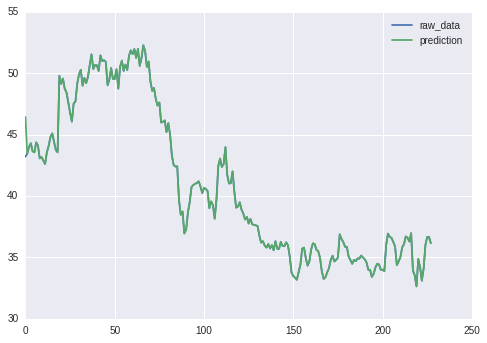

In [238]:
target_list = ['YHOO']
input_list = ["AAPL", "ORCL", "IBM", "INTC"]

start_date="2014-04-01"
end_date="2015-04-01"
input_data, date = get_data_by_list(input_list, start_date=start_date, end_date=end_date) 
target_data, date = get_data_by_list(target_list, start_date=start_date, end_date=end_date) 

T = len(input_data)
N_middle = T * 5
esn = ESN4(N_in=len(input_data[0]), N_middle=N_middle, N_out=len(target_data[0]))
start_time = T * 0.1
st = time.time()
output_data = esn.learning(input_data=input_data, target_data=target_data, start_time=start_time, sig=1.0)
elapsed = time.time() - st 

print ("learning time: %f" % elapsed)
plt.plot(target_data[start_time:], label="raw_data")
plt.plot(output_data[start_time:], label="prediction")
plt.legend()

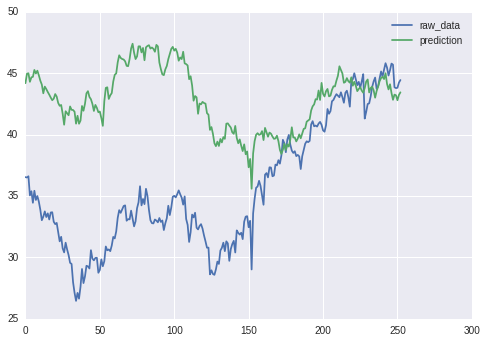

In [239]:
target_list = ['YHOO']
input_list = ["AAPL", "ORCL", "IBM", "INTC"]

start_date="2015-04-01"
end_date="2016-04-01"
input_data, date = get_data_by_list(input_list, start_date=start_date, end_date=end_date) 
target_data, date = get_data_by_list(target_list, start_date=start_date, end_date=end_date) 

output_data = esn.predict(input_data)

plt.plot(target_data, label="raw_data")
plt.plot(output_data, label="prediction")
plt.legend()

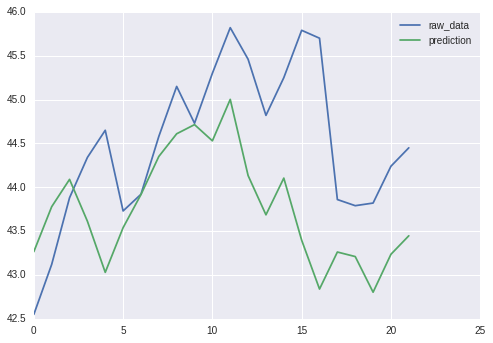

In [240]:
target_list = ['YHOO']
input_list = ["AAPL", "ORCL", "IBM", "INTC"]

start_date="2015-04-01"
end_date="2015-05-01"
input_data, date = get_data_by_list(input_list, start_date=start_date, end_date=end_date) 
target_data, date = get_data_by_list(target_list, start_date=start_date, end_date=end_date) 

output_data = esn.predict(input_data)

plt.plot(target_data, label="raw_data")
plt.plot(output_data, label="prediction")
plt.legend()

Let's change the scale of noise

learning time: 7.781206


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:19: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


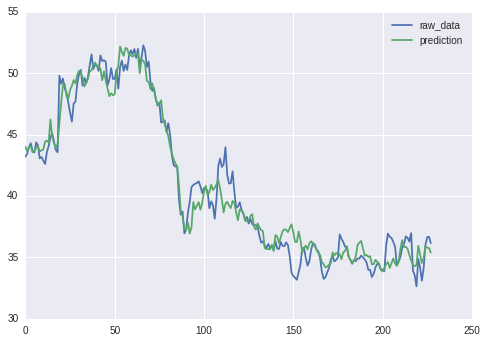

In [241]:
target_list = ['YHOO']
input_list = ["AAPL", "ORCL", "IBM", "INTC"]

start_date="2014-04-01"
end_date="2015-04-01"
input_data, date = get_data_by_list(input_list, start_date=start_date, end_date=end_date) 
target_data, date = get_data_by_list(target_list, start_date=start_date, end_date=end_date) 

T = len(input_data)
N_middle = T * 5
esn = ESN4(N_in=len(input_data[0]), N_middle=N_middle, N_out=len(target_data[0]))
start_time = T * 0.1
st = time.time()
output_data = esn.learning(input_data=input_data, target_data=target_data, start_time=start_time, sig=0)
elapsed = time.time() - st 

print ("learning time: %f" % elapsed)
plt.plot(target_data[start_time:], label="raw_data")
plt.plot(output_data[start_time:], label="prediction")
plt.legend()

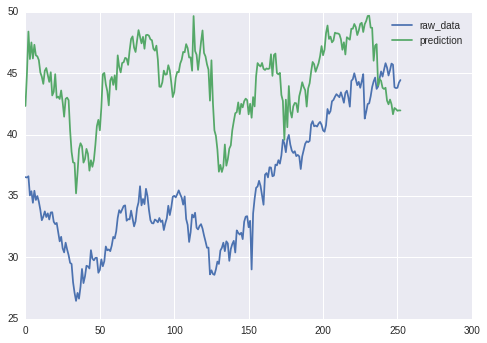

In [242]:
target_list = ['YHOO']
input_list = ["AAPL", "ORCL", "IBM", "INTC"]

start_date="2015-04-01"
end_date="2016-04-01"
input_data, date = get_data_by_list(input_list, start_date=start_date, end_date=end_date) 
target_data, date = get_data_by_list(target_list, start_date=start_date, end_date=end_date) 

output_data = esn.predict(input_data)

plt.plot(target_data, label="raw_data")
plt.plot(output_data, label="prediction")
plt.legend()

learning time: 6.825014


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:19: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


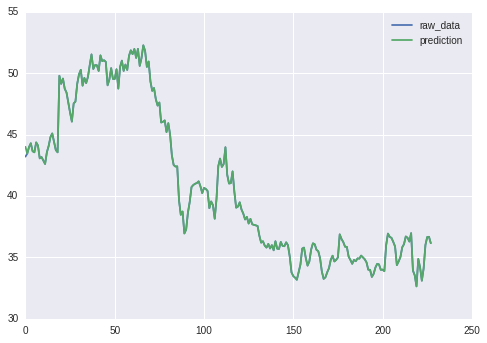

In [243]:
target_list = ['YHOO']
input_list = ["AAPL", "ORCL", "IBM", "INTC"]

start_date="2014-04-01"
end_date="2015-04-01"
input_data, date = get_data_by_list(input_list, start_date=start_date, end_date=end_date) 
target_data, date = get_data_by_list(target_list, start_date=start_date, end_date=end_date) 

T = len(input_data)
N_middle = T * 5
esn = ESN4(N_in=len(input_data[0]), N_middle=N_middle, N_out=len(target_data[0]))
start_time = T * 0.1
st = time.time()
output_data = esn.learning(input_data=input_data, target_data=target_data, start_time=start_time, sig=1.0)
elapsed = time.time() - st 

print ("learning time: %f" % elapsed)
plt.plot(target_data[start_time:], label="raw_data")
plt.plot(output_data[start_time:], label="prediction")
plt.legend()

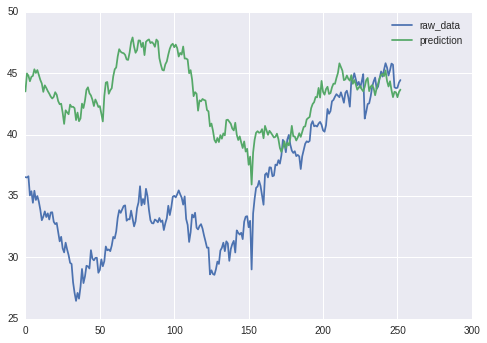

In [244]:
target_list = ['YHOO']
input_list = ["AAPL", "ORCL", "IBM", "INTC"]

start_date="2015-04-01"
end_date="2016-04-01"
input_data, date = get_data_by_list(input_list, start_date=start_date, end_date=end_date) 
target_data, date = get_data_by_list(target_list, start_date=start_date, end_date=end_date) 

output_data = esn.predict(input_data)

plt.plot(target_data, label="raw_data")
plt.plot(output_data, label="prediction")
plt.legend()

learning time: 7.066322


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:19: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


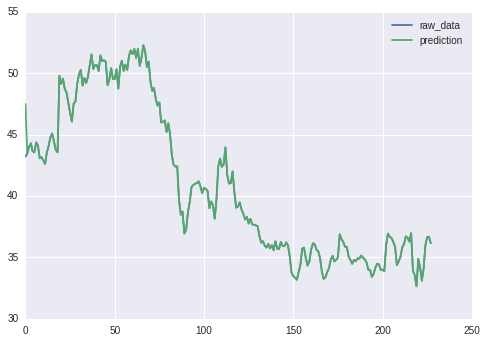

In [257]:
target_list = ['YHOO']
input_list = ["AAPL", "ORCL", "IBM", "INTC"]

start_date="2014-04-01"
end_date="2015-04-01"
input_data, date = get_data_by_list(input_list, start_date=start_date, end_date=end_date) 
target_data, date = get_data_by_list(target_list, start_date=start_date, end_date=end_date) 

T = len(input_data)
N_middle = T * 5
esn = ESN4(N_in=len(input_data[0]), N_middle=N_middle, N_out=len(target_data[0]))
start_time = T * 0.1
st = time.time()
output_data = esn.learning(input_data=input_data, target_data=target_data, start_time=start_time, sig=1.0)
elapsed = time.time() - st 

print ("learning time: %f" % elapsed)
plt.plot(target_data[start_time:], label="raw_data")
plt.plot(output_data[start_time:], label="prediction")
plt.legend()

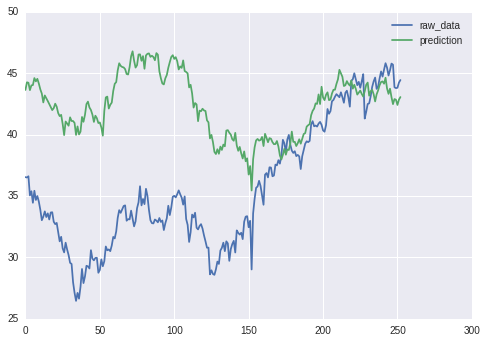

In [258]:
target_list = ['YHOO']
input_list = ["AAPL", "ORCL", "IBM", "INTC"]

start_date="2015-04-01"
end_date="2016-04-01"
input_data, date = get_data_by_list(input_list, start_date=start_date, end_date=end_date) 
target_data, date = get_data_by_list(target_list, start_date=start_date, end_date=end_date) 

output_data = esn.predict(input_data)

plt.plot(target_data, label="raw_data")
plt.plot(output_data, label="prediction")
plt.legend()

learning time: 56.232784


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:19: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


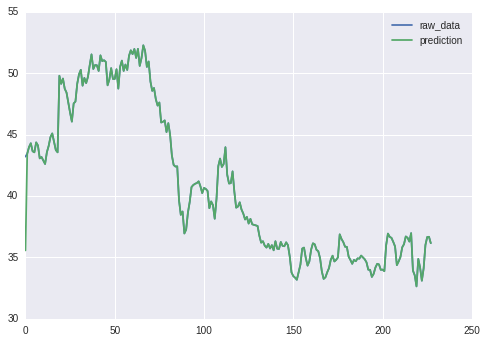

In [259]:
target_list = ['YHOO']
input_list = ["AAPL", "ORCL", "IBM", "INTC"]

start_date="2014-04-01"
end_date="2015-04-01"
input_data, date = get_data_by_list(input_list, start_date=start_date, end_date=end_date) 
target_data, date = get_data_by_list(target_list, start_date=start_date, end_date=end_date) 

T = len(input_data)
N_middle = T * 10
esn = ESN4(N_in=len(input_data[0]), N_middle=N_middle, N_out=len(target_data[0]))
start_time = T * 0.1
st = time.time()
output_data = esn.learning(input_data=input_data, target_data=target_data, start_time=start_time, sig=10.0)
elapsed = time.time() - st 

print ("learning time: %f" % elapsed)
plt.plot(target_data[start_time:], label="raw_data")
plt.plot(output_data[start_time:], label="prediction")
plt.legend()

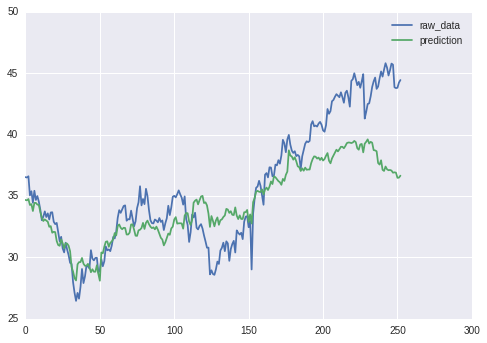

In [248]:
target_list = ['YHOO']
input_list = ["AAPL", "ORCL", "IBM", "INTC"]

start_date="2015-04-01"
end_date="2016-04-01"
input_data, date = get_data_by_list(input_list, start_date=start_date, end_date=end_date) 
target_data, date = get_data_by_list(target_list, start_date=start_date, end_date=end_date) 

output_data = esn.predict(input_data)

plt.plot(target_data, label="raw_data")
plt.plot(output_data, label="prediction")
plt.legend()

Try adding noise for prediction

In [222]:
class ESN5(object):
    
    def __init__(
            self, N_in, N_middle, N_out, 
            activation=np.tanh, activation_out=lambda x: x,
            activation_out_inv=lambda x: x,
            dense=0.15, scale=0.8, alpha=1.0, 
            W_in=None, W_middle=None, W_out=None
        ):
        """shape feature
        Args:
            N_in (int): The dimention of input
            N_middle (int): the number of hidden nodes
            N_out (int): the dimention of output
            activation (lambda): activation function of middle layer
            activation_out (lambda):
                activation function for output
            activation_out_inv (lambda):
                inverse function of activation_out
            dense (float): the degree of sparsity of W_in and W_middle
            scale (float): the scale of W_middle
            alpha (float): initialization for W_in and W_middle
                uniform_dist [-alpha, alpha]
            W_* (np.array): weitght for each layer
        """
        
        self.N_in = N_in
        self.N_out = N_out
        self.N_middle = N_middle
        self.activation = activation
        self.activation_out = activation_out
        self.activation_out_inv = activation_out_inv
        self.middle = np.zeros(shape=self.N_middle)
    
        if W_middle is None:
            # the number of non-zero elements
            num_w = int(N_middle * N_middle * dense)
            W_middle = np.zeros(shape=(N_middle, N_middle))
            for i in xrange(num_w):
                row = np.random.randint(low=0, high=N_middle)
                col = np.random.randint(low=0, high=N_middle)
                while(W_middle[row][col] != 0):
                    row = np.random.randint(low=0, high=N_middle)
                    col = np.random.randint(low=0, high=N_middle)
                u = np.random.uniform(low=-alpha, high=alpha)
                W_middle[row][col] = u
            #normalization
            eig_max = np.max(np.abs(np.linalg.eigvals(W_middle)))
            W_middle = W_middle / eig_max * scale
        self.W_middle = W_middle
        
        if W_in is None:
            # the number of non-zero elements
            num_w = int(N_in * N_middle  * dense)
            W_in = np.zeros(shape=(N_middle, N_in))
            for i in xrange(num_w):
                row = np.random.randint(low=0, high=N_middle)
                col = np.random.randint(low=0, high=N_in)
                while(W_in[row][col] != 0):
                    row = np.random.randint(low=0, high=N_middle)
                    col = np.random.randint(low=0, high=N_in)
                u = np.random.uniform(low=-alpha, high=alpha)
                W_in[row][col] = u
            # bias
            num_b = int(N_middle  * dense)
            bias_in = np.zeros(shape=N_middle)
            for i in xrange(num_b):
                row = np.random.randint(low=0, high=N_middle)
                while(bias_in[row] != 0):
                    row = np.random.randint(low=0, high=N_middle)
                u = np.random.uniform(low=-alpha, high=alpha)
                bias_in[row] = u
            W_in = np.c_[bias_in, W_in]
        self.W_in = W_in
        
        
    def learning(self, input_data, target_data, start_time, L2=1.0e-2, sig=1.0e-2):
        N_data = len(input_data)
        Y = []
        X = []
        # initalization
        middle = np.zeros(shape=self.N_middle)
        output = np.zeros(shape=self.N_out)
        middle_data = []
        for i in xrange(N_data):
            new_m = self.activation(
                np.dot(self.W_in, np.r_[1.0, input_data[i]]) \
                + np.dot(self.W_middle, middle)
                )\
                + sig*np.random.randn(self.N_middle)
            
            if i >= start_time:
                # minimize ||Y - X * W.T|| ** 2+ L2 * ||W|| ** 2
                Y.append(self.activation_out_inv(target_data[i]))
                X.append(np.r_[1.0, input_data[i], new_m])
            
            middle = new_m  
            middle_data.append(middle)
            
        Y = np.array(Y)
        X = np.array(X)
        #keep middle data for predcition
        self.middle = middle
                                    
        if L2 == 0:
            X_inv = np.real(np.linalg.pinv(X.T))
        else:
            X_inv = np.dot(X, np.linalg.inv(L2 * np.identity(self.N_in + self.N_middle + 1) + np.dot(X.T, X)))
        self.W_out = np.dot(Y.T, X_inv)
        pre_out = np.c_[np.ones(N_data), input_data, middle_data]
        return self.activation_out(np.dot(self.W_out, pre_out.T).T)
    
    def predict(self, input_data, sig=1.0):
        output_data = []
        N_data = len(input_data)
        #initalization
        middle = self.middle.copy()
        for i in xrange(N_data):
            new_m = self.activation(
                np.dot(self.W_in, np.r_[1.0, input_data[i]]) \
                + np.dot(self.W_middle, middle)
                )\
                + sig*np.random.randn(self.N_middle)
            output = self.activation_out(np.dot(self.W_out, np.r_[1.0, input_data[i], new_m]))
            middle = new_m
            output_data.append(output)
            
        return np.array(output_data)

learning time: 6.933207


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:19: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


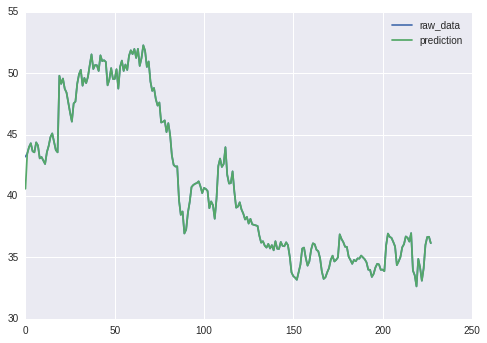

In [223]:
target_list = ['YHOO']
input_list = ["AAPL", "ORCL", "IBM", "INTC"]

start_date="2014-04-01"
end_date="2015-04-01"
input_data, date = get_data_by_list(input_list, start_date=start_date, end_date=end_date) 
target_data, date = get_data_by_list(target_list, start_date=start_date, end_date=end_date) 

T = len(input_data)
N_middle = T * 5
esn = ESN5(N_in=len(input_data[0]), N_middle=N_middle, N_out=len(target_data[0]))
start_time = T * 0.1
st = time.time()
output_data = esn.learning(input_data=input_data, target_data=target_data, start_time=start_time, sig=10.0)
elapsed = time.time() - st 

print ("learning time: %f" % elapsed)
plt.plot(target_data[start_time:], label="raw_data")
plt.plot(output_data[start_time:], label="prediction")
plt.legend()

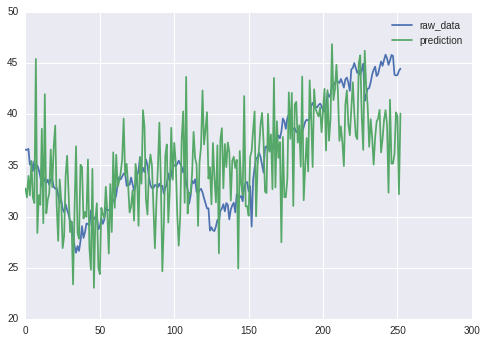

In [224]:
target_list = ['YHOO']
input_list = ["AAPL", "ORCL", "IBM", "INTC"]

start_date="2015-04-01"
end_date="2016-04-01"
input_data, date = get_data_by_list(input_list, start_date=start_date, end_date=end_date) 
target_data, date = get_data_by_list(target_list, start_date=start_date, end_date=end_date) 

output_data = esn.predict(input_data, sig=10)

plt.plot(target_data, label="raw_data")
plt.plot(output_data, label="prediction")
plt.legend()

As I expected, it goes noisy.

It's better not to use noise for prediction.

In [251]:
a = [1, 2, 3]
b = map(float, a)

In [253]:
print (b)

[1.0, 2.0, 3.0]


# Model with feedback

In [300]:
class ESN6(object):
    
    def __init__(
            self, N_in, N_middle, N_out, 
            activation=np.tanh, activation_out=lambda x: x,
            activation_out_inv=lambda x: x,
            dense=0.15, scale=0.8, alpha=1.0, 
            W_in=None, W_middle=None, W_out=None, W_fb=None
        ):
        """shape feature
        Args:
            N_in (int): The dimention of input
            N_middle (int): the number of hidden nodes
            N_out (int): the dimention of output
            activation (lambda): activation function of middle layer
            activation_out (lambda):
                activation function for output
            activation_out_inv (lambda):
                inverse function of activation_out
            dense (float): the degree of sparsity of W_in and W_middle
            scale (float): the scale of W_middle
            alpha (float): initialization for W_in and W_middle
                uniform_dist [-alpha, alpha]
            W_* (np.array): weitght for each layer
        """
        
        self.N_in = N_in
        self.N_out = N_out
        self.N_middle = N_middle
        self.activation = activation
        self.activation_out = activation_out
        self.activation_out_inv = activation_out_inv
        self.middle = np.zeros(shape=self.N_middle)
    
        if W_middle is None:
            # the number of non-zero elements
            num_w = int(N_middle * N_middle * dense)
            W_middle = np.zeros(shape=(N_middle, N_middle))
            for i in xrange(num_w):
                row = np.random.randint(low=0, high=N_middle)
                col = np.random.randint(low=0, high=N_middle)
                while(W_middle[row][col] != 0):
                    row = np.random.randint(low=0, high=N_middle)
                    col = np.random.randint(low=0, high=N_middle)
                u = np.random.uniform(low=-alpha, high=alpha)
                W_middle[row][col] = u
            #normalization
            eig_max = np.max(np.abs(np.linalg.eigvals(W_middle)))
            W_middle = W_middle / eig_max * scale
        self.W_middle = W_middle
        
        if W_in is None:
            # the number of non-zero elements
            num_w = int(N_in * N_middle  * dense)
            W_in = np.zeros(shape=(N_middle, N_in))
            for i in xrange(num_w):
                row = np.random.randint(low=0, high=N_middle)
                col = np.random.randint(low=0, high=N_in)
                while(W_in[row][col] != 0):
                    row = np.random.randint(low=0, high=N_middle)
                    col = np.random.randint(low=0, high=N_in)
                u = np.random.uniform(low=-alpha, high=alpha)
                W_in[row][col] = u
            # bias
            num_b = int(N_middle  * dense)
            bias_in = np.zeros(shape=N_middle)
            for i in xrange(num_b):
                row = np.random.randint(low=0, high=N_middle)
                while(bias_in[row] != 0):
                    row = np.random.randint(low=0, high=N_middle)
                u = np.random.uniform(low=-alpha, high=alpha)
                bias_in[row] = u
            W_in = np.c_[bias_in, W_in]
        self.W_in = W_in
        
        if W_out is None:
            # the number of non-zero elements
            num_w = int(N_out * (N_middle + N_in)  * dense)
            W_out = np.zeros(shape=(N_out, N_middle + N_in))
            for i in xrange(num_w):
                row = np.random.randint(low=0, high=N_out)
                col = np.random.randint(low=0, high=N_middle + N_in)
                while(W_out[row][col] != 0):
                    row = np.random.randint(low=0, high=N_out)
                    col = np.random.randint(low=0, high=N_middle + N_in)
                u = np.random.uniform(low=-alpha, high=alpha)
                W_out[row][col] = u
            # bias
            num_b = int(N_out  * dense)
            bias_out = np.zeros(shape=N_out)
            for i in xrange(num_b):
                row = np.random.randint(low=0, high=N_out)
                while(bias_out[row] != 0):
                    row = np.random.randint(low=0, high=N_out)
                u = np.random.uniform(low=-alpha, high=alpha)
                bias_out[row] = u
            W_out = np.c_[bias_out, W_out]
        self.W_out = W_out
        
        if W_fb is None:
            # the number of non-zero elements
            num_w = int(N_out * N_middle  * dense)
            W_fb = np.zeros(shape=(N_middle, N_out))
            for i in xrange(num_w):
                row = np.random.randint(low=0, high=N_middle)
                col = np.random.randint(low=0, high=N_out)
                while(W_fb[row][col] != 0):
                    row = np.random.randint(low=0, high=N_middle)
                    col = np.random.randint(low=0, high=N_out)
                u = np.random.uniform(low=-alpha, high=alpha)
                W_fb[row][col] = u
            # bias
            num_b = int(N_middle  * dense)
            bias_fb = np.zeros(shape=N_middle)
            for i in xrange(num_b):
                row = np.random.randint(low=0, high=N_middle)
                while(bias_fb[row] != 0):
                    row = np.random.randint(low=0, high=N_middle)
                u = np.random.uniform(low=-alpha, high=alpha)
                bias_fb[row] = u
            W_fb = np.c_[bias_fb, W_fb]
        self.W_fb = W_fb     
        
        
    def learning(self, input_data, target_data, start_time, L2=1.0e-2, sig=1.0e-2):
        N_data = len(input_data)
        Y = []
        X = []
        # initalization
        middle = np.zeros(shape=self.N_middle)
        output = np.zeros(shape=self.N_out)
        middle_data = []
        for i in xrange(N_data):
            new_m = self.activation(
                np.dot(self.W_in, np.r_[1.0, input_data[i]]) \
                + np.dot(self.W_middle, middle)\
                + np.dot(self.W_fb, np.r_[1.0, output])
                )\
                + sig*np.random.randn(self.N_middle)
                
            new_o = self.activation_out(np.dot(self.W_out, np.r_[1.0, input_data[i], new_m]))
            
            middle = new_m  
            middle_data.append(middle)
            output = new_o
            
            if i >= start_time:
                # minimize ||Y - X * W.T|| ** 2+ L2 * ||W|| ** 2
                Y.append(self.activation_out_inv(target_data[i]))
                X.append(np.r_[1.0, input_data[i], new_m])
            
                Y_tilde = np.array(Y)
                X_tilde = np.array(X)
                                    
                if L2 == 0:
                    X_inv = np.real(np.linalg.pinv(X_tilde.T))
                else:
                    X_inv = np.dot(X_tilde, np.linalg.inv(L2 * np.identity(self.N_in + self.N_middle + 1)\
                            + np.dot(X_tilde.T, X_tilde)
                        )
                    )
                self.W_out = np.dot(Y_tilde.T, X_inv)
        
        #keep middle, output data for predcition
        self.middle = middle
        self.output = output
        pre_out = np.c_[np.ones(N_data), input_data, middle_data]
        return self.activation_out(np.dot(self.W_out, pre_out.T).T)
    
    def predict(self, input_data, sig=0):
        output_data = []
        N_data = len(input_data)
        #initalization
        middle = self.middle
        output = self.output
        for i in xrange(N_data):
            middle = self.activation(
                np.dot(self.W_in, np.r_[1.0, input_data[i]]) \
                + np.dot(self.W_middle, middle)\
                + np.dot(self.W_fb, np.r_[1.0, output])
                )\
                + sig*np.random.randn(self.N_middle)
            output = self.activation_out(np.dot(self.W_out, np.r_[1.0, input_data[i], middle]))
            output_data.append(output)
            
        return np.array(output_data)

In [12]:
target_list = ['YHOO']
input_list = ["AAPL", "ORCL", "IBM", "INTC"]

start_date="2014-04-01"
end_date="2015-04-01"
input_data, date = get_data_by_list(input_list, start_date=start_date, end_date=end_date) 
target_data, date = get_data_by_list(target_list, start_date=start_date, end_date=end_date) 

start_date="2015-04-01"
end_date="2016-04-01"
input_data_pred, date = get_data_by_list(input_list, start_date=start_date, end_date=end_date) 
target_data_pred, date = get_data_by_list(target_list, start_date=start_date, end_date=end_date) 

learning time: 14.781297


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:11: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


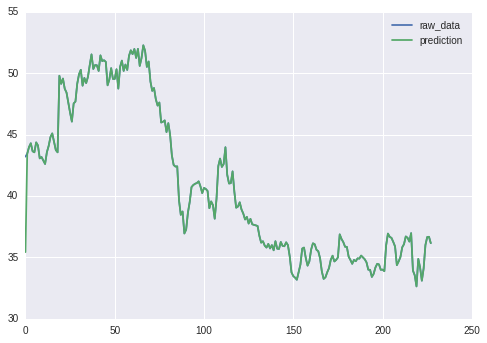

In [303]:
T = len(input_data)
N_middle = T
esn = ESN6(N_in=len(input_data[0]), N_middle=N_middle, N_out=len(target_data[0]))
start_time = T * 0.1
st = time.time()
output_data = esn.learning(input_data=input_data, target_data=target_data, start_time=start_time, sig=1.0)
elapsed = time.time() - st 

print ("learning time: %f" % elapsed)
plt.plot(target_data[start_time:], label="raw_data")
plt.plot(output_data[start_time:], label="prediction")
plt.legend()

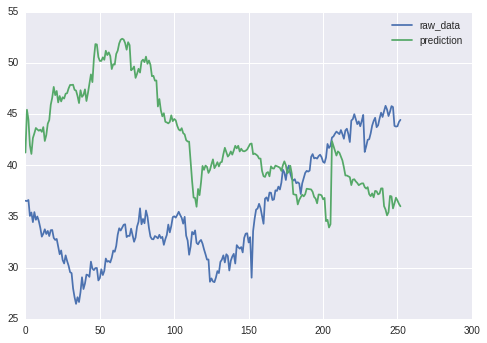

In [304]:
output_data_pred = esn.predict(input_data)

plt.plot(target_data_pred, label="raw_data")
plt.plot(output_data_pred, label="prediction")
plt.legend()

learning time: 1559.334594


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:11: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


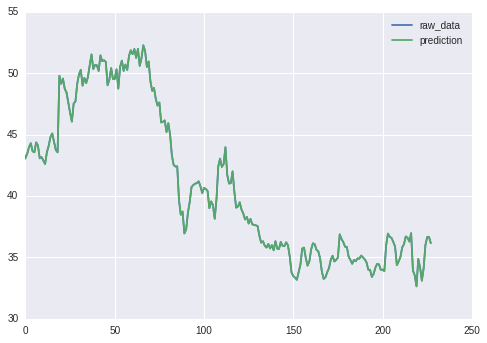

In [305]:
T = len(input_data)
N_middle = T * 5
esn = ESN6(N_in=len(input_data[0]), N_middle=N_middle, N_out=len(target_data[0]))
start_time = T * 0.1
st = time.time()
output_data = esn.learning(input_data=input_data, target_data=target_data, start_time=start_time, sig=1.0)
elapsed = time.time() - st 

print ("learning time: %f" % elapsed)
plt.plot(target_data[start_time:], label="raw_data")
plt.plot(output_data[start_time:], label="prediction")
plt.legend()

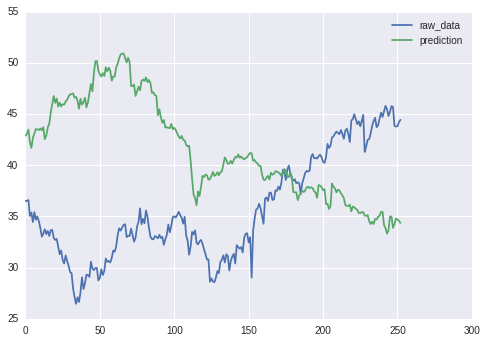

In [ ]:
output_data_pred = esn.predict(input_data)

plt.plot(target_data_pred, label="raw_data")
plt.plot(output_data_pred, label="prediction")
plt.legend()

In [ ]:
T = len(input_data)
N_middle = T * 10
esn = ESN6(N_in=len(input_data[0]), N_middle=N_middle, N_out=len(target_data[0]))
start_time = T * 0.1
st = time.time()
output_data = esn.learning(input_data=input_data, target_data=target_data, start_time=start_time, sig=1.0)
elapsed = time.time() - st 

print ("learning time: %f" % elapsed)
plt.plot(target_data[start_time:], label="raw_data")
plt.plot(output_data[start_time:], label="prediction")
plt.legend()

In [ ]:
output_data_pred = esn.predict(input_data)

plt.plot(target_data_pred, label="raw_data")
plt.plot(output_data_pred, label="prediction")
plt.legend()

# Leaky Model

In [14]:
import numpy as np

class ESN7(object):
    
    def __init__(
            self, N_in, N_middle, N_out, 
            activation=np.tanh, activation_out=lambda x: x,
            activation_out_inv=lambda x: x,
            dense=0.15, scale=0.8, alpha=1.0, leaky_rate=0.5,
            W_in=None, W_middle=None, W_out=None
        ):
        """shape feature
        Args:
            N_in (int): The dimention of input
            N_middle (int): the number of hidden nodes
            N_out (int): the dimention of output
            activation (lambda): activation function of middle layer
            activation_out (lambda):
                activation function for output
            activation_out_inv (lambda):
                inverse function of activation_out
            dense (float): the degree of sparsity of W_in and W_middle
            scale (float): the scale of W_middle
            alpha (float): initialization for W_in and W_middle
                uniform_dist [-alpha, alpha]
            W_* (np.array): weitght for each layer
        """
        
        self.N_in = N_in
        self.N_out = N_out
        self.N_middle = N_middle
        self.activation = activation
        self.activation_out = activation_out
        self.activation_out_inv = activation_out_inv
        self.middle = np.zeros(shape=self.N_middle)
        self.leaky_rate = leaky_rate
    
        if W_middle is None:
            # the number of non-zero elements
            num_w = int(N_middle * N_middle * dense)
            W_middle = np.zeros(shape=(N_middle, N_middle))
            for i in xrange(num_w):
                row = np.random.randint(low=0, high=N_middle)
                col = np.random.randint(low=0, high=N_middle)
                while(W_middle[row][col] != 0):
                    row = np.random.randint(low=0, high=N_middle)
                    col = np.random.randint(low=0, high=N_middle)
                u = np.random.uniform(low=-alpha, high=alpha)
                W_middle[row][col] = u
            #normalization
            eig_max = np.max(np.abs(np.linalg.eigvals(W_middle)))
            W_middle = W_middle / eig_max * scale
        self.W_middle = W_middle
        
        if W_in is None:
            # the number of non-zero elements
            num_w = int(N_in * N_middle  * dense)
            W_in = np.zeros(shape=(N_middle, N_in))
            for i in xrange(num_w):
                row = np.random.randint(low=0, high=N_middle)
                col = np.random.randint(low=0, high=N_in)
                while(W_in[row][col] != 0):
                    row = np.random.randint(low=0, high=N_middle)
                    col = np.random.randint(low=0, high=N_in)
                u = np.random.uniform(low=-alpha, high=alpha)
                W_in[row][col] = u
            # bias
            num_b = int(N_middle  * dense)
            bias_in = np.zeros(shape=N_middle)
            for i in xrange(num_b):
                row = np.random.randint(low=0, high=N_middle)
                while(bias_in[row] != 0):
                    row = np.random.randint(low=0, high=N_middle)
                u = np.random.uniform(low=-alpha, high=alpha)
                bias_in[row] = u
            W_in = np.c_[bias_in, W_in]
        self.W_in = W_in
        
        
    def learning(self, input_data, target_data, start_time, L2=1.0e-2, sig=1.0e-2):
        N_data = len(input_data)
        Y = []
        X = []
        # initalization
        middle = np.zeros(shape=self.N_middle)
        output = np.zeros(shape=self.N_out)
        middle_data = []
        for i in xrange(N_data):
            m_tilde = self.activation(
                np.dot(self.W_in, np.r_[1.0, input_data[i]]) \
                + np.dot(self.W_middle, middle)
                )\
                + sig*np.random.randn(self.N_middle)
            new_m = self.leaky_rate * m_tilde + (1 - self.leaky_rate) * middle
            
            if i >= start_time:
                # minimize ||Y - X * W.T|| ** 2+ L2 * ||W|| ** 2
                Y.append(self.activation_out_inv(target_data[i]))
                X.append(np.r_[1.0, input_data[i], new_m])
            
            middle = new_m  
            middle_data.append(middle)
            
        Y = np.array(Y)
        X = np.array(X)
        #keep middle data for predcition
        self.middle = middle
                                    
        if L2 == 0:
            X_inv = np.real(np.linalg.pinv(X.T))
        else:
            X_inv = np.dot(X, np.linalg.inv(L2 * np.identity(self.N_in + self.N_middle + 1) + np.dot(X.T, X)))
        self.W_out = np.dot(Y.T, X_inv)
        pre_out = np.c_[np.ones(N_data), input_data, middle_data]
        return self.activation_out(np.dot(self.W_out, pre_out.T).T)
    
    def predict(self, input_data, sig=0):
        output_data = []
        N_data = len(input_data)
        #initalization
        middle = self.middle.copy()
        for i in xrange(N_data):
            m_tilde = self.activation(
                np.dot(self.W_in, np.r_[1.0, input_data[i]]) \
                + np.dot(self.W_middle, middle)
                )\
                + sig*np.random.randn(self.N_middle)
            new_m = self.leaky_rate * m_tilde + (1 - self.leaky_rate) * middle
            
            output = self.activation_out(np.dot(self.W_out, np.r_[1.0, input_data[i], new_m]))
            middle = new_m
            output_data.append(output)
            
        return np.array(output_data)

learning time: 0.125714


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:11: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


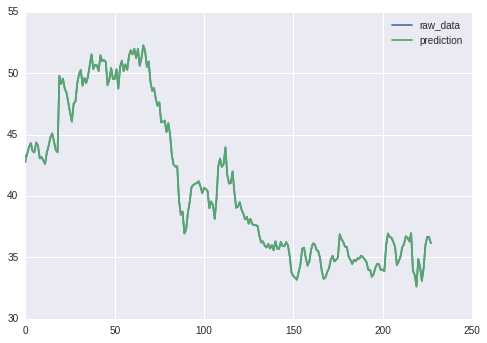

In [17]:
T = len(input_data)
N_middle = T
esn = ESN7(N_in=len(input_data[0]), N_middle=N_middle, N_out=len(target_data[0]),
          leaky_rate=0.3)
start_time = T * 0.1
st = time.time()
output_data = esn.learning(input_data=input_data, target_data=target_data, start_time=start_time, sig=1.0)
elapsed = time.time() - st 

print ("learning time: %f" % elapsed)
plt.plot(target_data[start_time:], label="raw_data")
plt.plot(output_data[start_time:], label="prediction")
plt.legend()

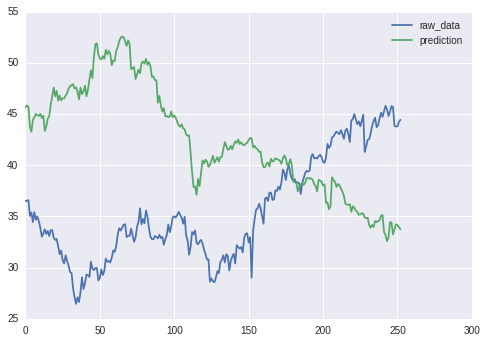

In [18]:
output_data_pred = esn.predict(input_data)

plt.plot(target_data_pred, label="raw_data")
plt.plot(output_data_pred, label="prediction")
plt.legend()

learning time: 6.622162


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:11: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


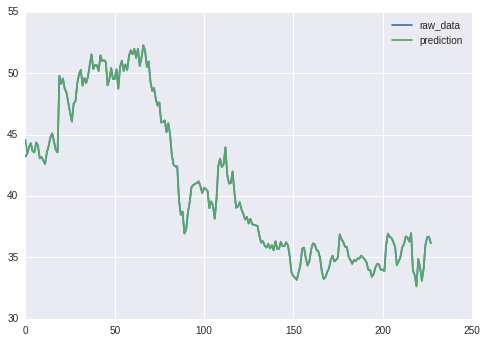

In [35]:
T = len(input_data)
N_middle = T * 5
esn = ESN7(N_in=len(input_data[0]), N_middle=N_middle, N_out=len(target_data[0]),
          leaky_rate=0.8)
start_time = T * 0.1
st = time.time()
output_data = esn.learning(input_data=input_data, target_data=target_data, start_time=start_time, sig=1.0)
elapsed = time.time() - st 

print ("learning time: %f" % elapsed)
plt.plot(target_data[start_time:], label="raw_data")
plt.plot(output_data[start_time:], label="prediction")
plt.legend()

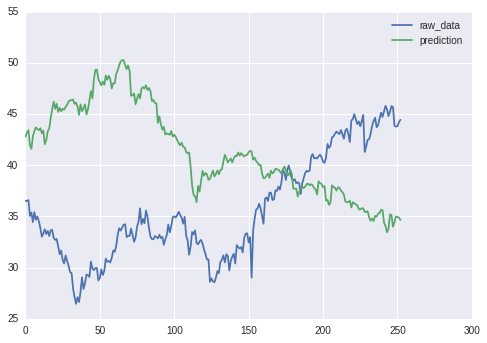

In [36]:
output_data_pred = esn.predict(input_data)

plt.plot(target_data_pred, label="raw_data")
plt.plot(output_data_pred, label="prediction")
plt.legend()

learning time: 47.912207


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:11: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


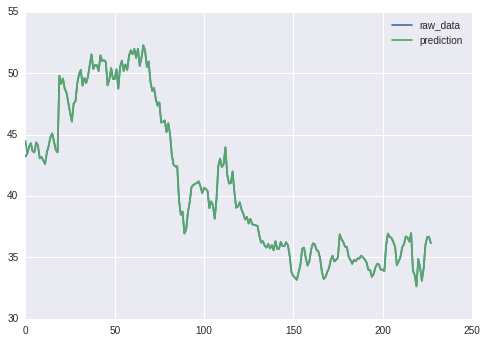

In [38]:
T = len(input_data)
N_middle = T * 10
esn = ESN7(N_in=len(input_data[0]), N_middle=N_middle, N_out=len(target_data[0]),
          leaky_rate=0.8)
start_time = T * 0.1
st = time.time()
output_data = esn.learning(input_data=input_data, target_data=target_data, start_time=start_time, sig=1.0)
elapsed = time.time() - st 

print ("learning time: %f" % elapsed)
plt.plot(target_data[start_time:], label="raw_data")
plt.plot(output_data[start_time:], label="prediction")
plt.legend()

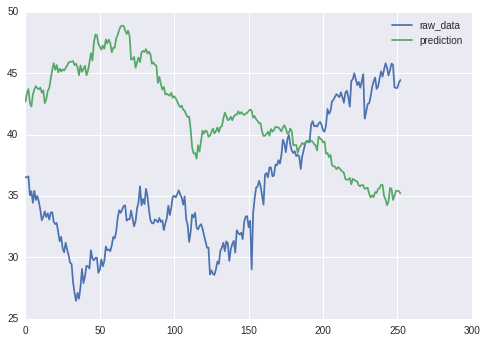

In [39]:
output_data_pred = esn.predict(input_data)

plt.plot(target_data_pred, label="raw_data")
plt.plot(output_data_pred, label="prediction")
plt.legend()